In [23]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
from tqdm import tqdm

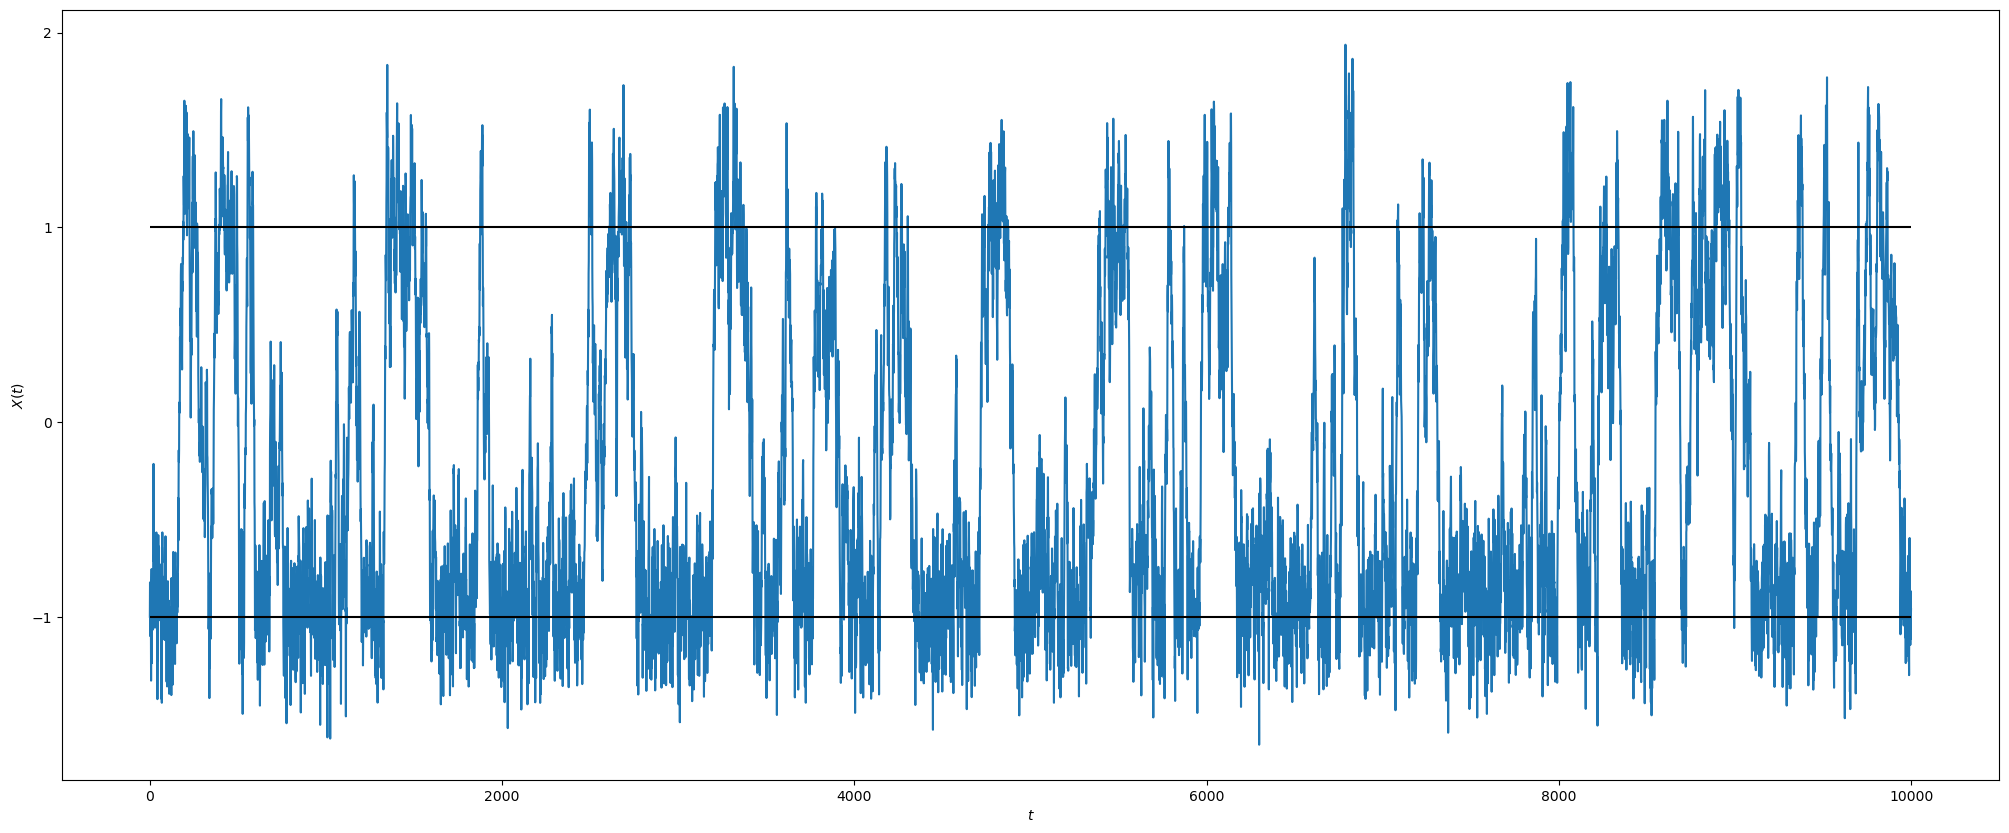

In [ ]:
class model_params():
    def __init__(self, x_init=1.0, dt=0.1, time_horizon=10.0, num_trajectories=1):
        self.x_init = np.ones((1, num_trajectories)) * x_init
        self.dt = dt
        self.time_horizon = time_horizon
        self.num_steps = int(self.time_horizon/self.dt)
        self.time_vec = np.linspace(0, self.time_horizon, self.num_steps)
        self.num_trajectories = num_trajectories
        self.noise = random.normal(loc=0.0, scale = dt**(1/2), size=(self.num_steps, self.num_trajectories))

class climate_sde(model_params):
    def __init__(self, potential, x_init=0.0, dt=0.1,  time_horizon=100, num_trajectories=1, want_jumps: bool = True, jump_mult: float = 1.5):
        super().__init__(x_init=x_init, dt=dt, time_horizon=time_horizon, num_trajectories=num_trajectories)
        self.jump_mult = jump_mult
        
        if want_jumps == True:
            self.epsilon = (4.29 * 2/ np.log(self.time_horizon)) * self.jump_mult
        else:
            self.epsilon = 4.29 / np.log(self.time_horizon) - 0.001
        
        self.potential = potential

    def mu(self, x, t):
        return -self.potential(x, t)
    
    def sigma(self, x=0.0, t=0.0):
        return self.epsilon ** (1/2)

class solver():
    def __init__(self, sde):
        self.sde = sde

    def euler_maruyama(self):
        x = np.zeros((self.sde.num_steps, self.sde.num_trajectories))
        x[0] = self.sde.x_init

        for i in tqdm(range(self.sde.num_steps - 1)):
            curr_t = self.sde.time_vec[i]
            curr_x = x[i, :]
            dW = self.sde.noise[i, :]

            x[i+1, :] = curr_x + self.sde.mu(curr_x, curr_t)*self.sde.dt + self.sde.sigma(curr_x, curr_t) * dW

            # if np.isnan(x[i+1, :]).any() or np.isinf(x[i+1, :]).any():
            #     raise ValueError(f'Encountered: {x[i+1, :]}')

        return x


def const_neg_potential(x, t, period=100):
    t = 25                                   # re-define t to place minima on negative.
    a1 = 0
    a2 = -3.2
    sin_scale = 3
    a3 = sin_scale*np.sin(2*np.pi*t/period)
    a4 = 0.1
    a5 = -(3/5) * a3
    a6 = 1

    all_scale = 1.13
    
    return all_scale*(a6*6*x**5 + a5*5*x**4 + a4*4*x**3 + a3*3*x**2 + a2*2*x + a1)


climate = climate_sde(const_neg_potential, x_init=-1, dt=0.01, time_horizon=100, num_trajectories=1, want_jumps=True, jump_mult=2)
em_solve = solver(climate)
em_sim = em_solve.euler_maruyama()


plt.figure(figsize=(25,10))
plt.plot(em_sim)
plt.yticks([-2, -1, 0, 1, 2])
plt.hlines([1, -1], xmax=climate.time_vec[-1] * (1/climate.dt), xmin=climate.time_vec[0], colors="black")
plt.xlabel('$t$')
plt.ylabel('$X(t)$')
plt.show()

100%|██████████| 9999/9999 [00:00<00:00, 58780.52it/s]


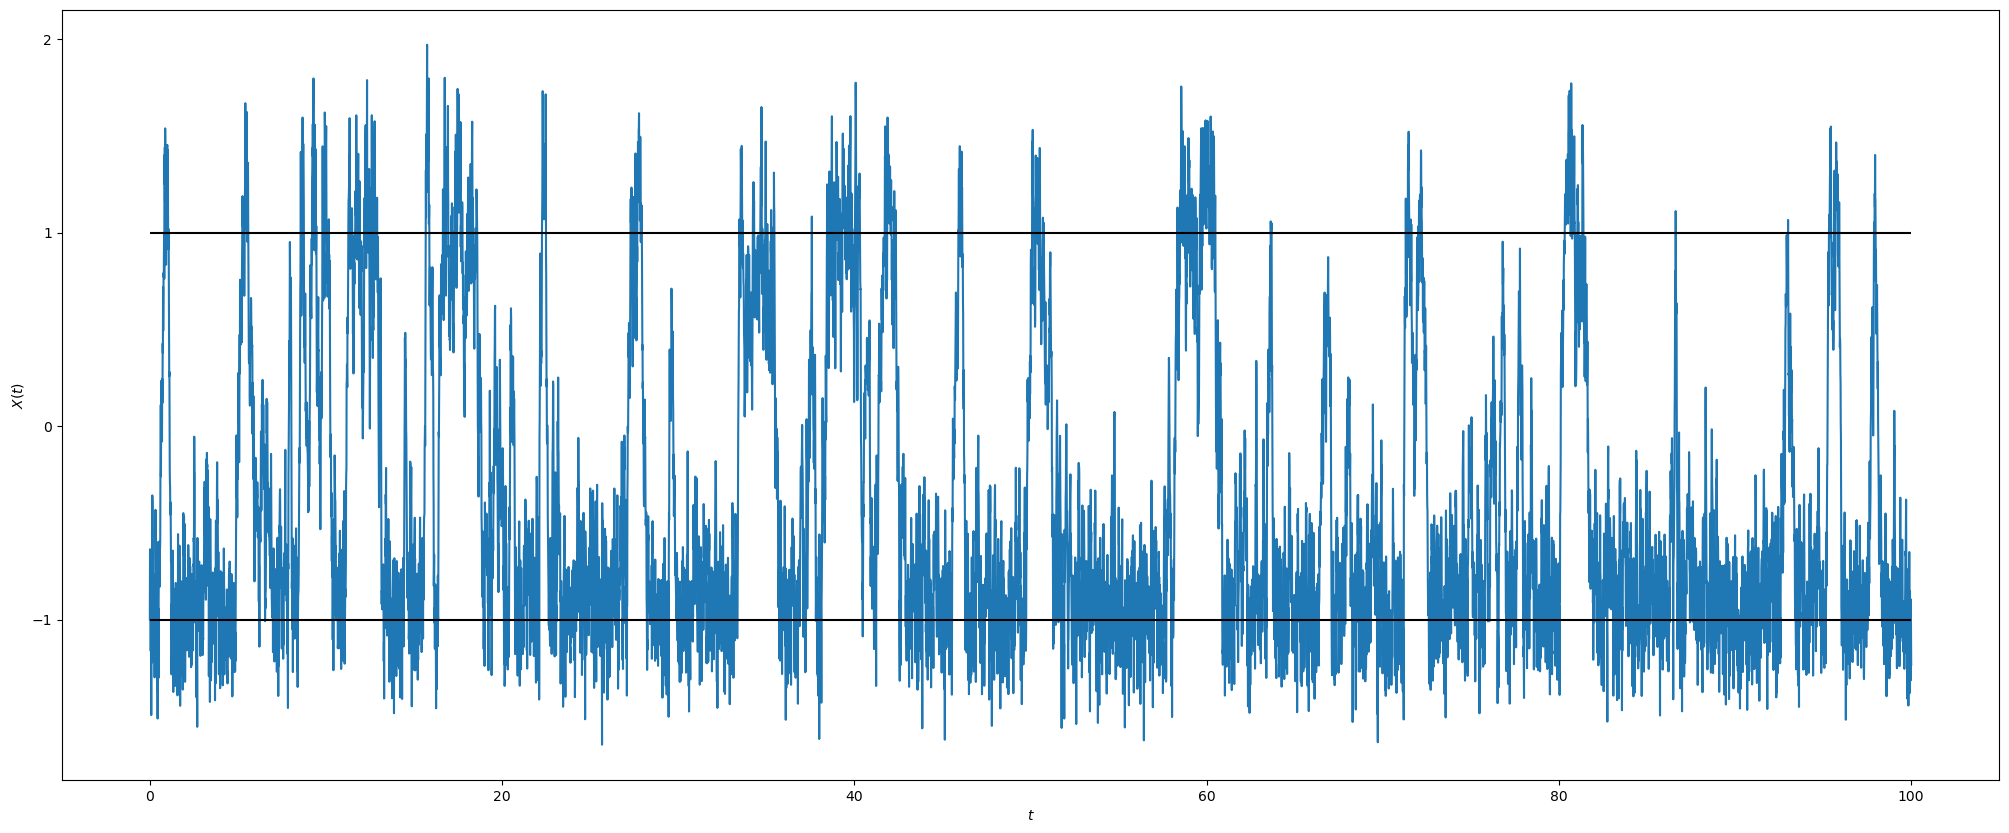

In [68]:
import numpy as np
from numpy import random
from tqdm import tqdm
import matplotlib.pyplot as plt

def create_model_params(x_init=1.0, dt=0.1, time_horizon=10.0, num_trajectories=1):
    """Creates basic model parameters for the simulation."""
    params = {
        'x_init': np.ones((num_trajectories, 1)) * x_init,  # Changed to (num_trajectories, 1)
        'dt': dt,
        'time_horizon': time_horizon,
        'num_steps': int(time_horizon/dt),
        'num_trajectories': num_trajectories
    }
    params['time_vec'] = np.linspace(0, time_horizon, params['num_steps'])
    params['noise'] = random.normal(loc=0.0, scale=dt**(1/2), 
                                  size=(num_trajectories, params['num_steps']))  # Changed to (num_trajectories, num_steps)
    return params

def create_climate_params(potential, params, want_jumps=True, jump_mult=1.5):
    """Adds climate-specific parameters to the base parameters."""
    climate_params = params.copy()
    
    if want_jumps:
        epsilon = (4.29 * 2 / np.log(params['time_horizon'])) * jump_mult
    else:
        epsilon = 4.29 / np.log(params['time_horizon']) - 0.001
        
    climate_params['epsilon'] = epsilon
    climate_params['potential'] = potential
    return climate_params

def mu(x, t, potential):
    """Drift function."""
    return -potential(x, t)

def sigma(x, t, epsilon):
    """Diffusion function."""
    return epsilon ** (1/2)

def euler_maruyama(params):
    """Implements the Euler-Maruyama numerical scheme."""
    x = np.zeros((params['num_trajectories'], params['num_steps']))  # Changed to (num_trajectories, num_steps)
    x[:, 0] = params['x_init'].flatten()  # Set initial conditions for all trajectories
    
    for i in tqdm(range(params['num_steps'] - 1)):
        curr_t = params['time_vec'][i]
        curr_x = x[:, i]  # Current state for all trajectories
        dW = params['noise'][:, i]  # Noise for current step
        
        x[:, i+1] = (curr_x + 
                     mu(curr_x, curr_t, params['potential']) * params['dt'] + 
                     sigma(curr_x, curr_t, params['epsilon']) * dW)
    
    return x

def const_neg_potential(x, t, period=100):
    """Defines the potential function."""
    t = 25  # re-define t to place minima on negative
    a1, a2, a3, a4, a5, a6 = 0, -3.2, 3*np.sin(2*np.pi*t/period), 0.1, -(3/5)*3*np.sin(2*np.pi*t/period), 1
    all_scale = 1.13
    
    return all_scale * (a6*6*x**5 + a5*5*x**4 + a4*4*x**3 + a3*3*x**2 + a2*2*x + a1)

def plot_simulation(simulation, params):
    """Plots the simulation results."""
    plt.figure(figsize=(25,10))
    for i in range(params['num_trajectories']):
        plt.plot(params['time_vec'], simulation[i, :])  # Plot each trajectory
    plt.yticks([-2, -1, 0, 1, 2])
    plt.hlines([1, -1], xmax=params['time_vec'][-1], xmin=params['time_vec'][0], colors="black")
    plt.xlabel('$t$')
    plt.ylabel('$X(t)$')
    plt.show()

def run_simulation(x_init=-1, dt=0.01, time_horizon=100, num_trajectories=1, 
                  want_jumps=True, jump_mult=2):
    # Create base parameters
    base_params = create_model_params(x_init=x_init, dt=dt, 
                                    time_horizon=time_horizon, 
                                    num_trajectories=num_trajectories)
    
    # Add climate-specific parameters
    climate_params = create_climate_params(const_neg_potential, base_params, 
                                         want_jumps=want_jumps, 
                                         jump_mult=jump_mult)
    
    # Run simulation
    simulation = euler_maruyama(climate_params)
    
    # Plot results
    plot_simulation(simulation, climate_params)
    
    return simulation, climate_params

# Run the simulation
simulation, params = run_simulation()